In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.1 MB/s eta 0:00:00


In [ ]:
# ========================================
# 1. Introduction & Setup
# ========================================

# This notebook demonstrates an end-to-end workflow:
# EDA, data cleaning, feature engineering,
# modeling with XGBoost, hyperparameter tuning using Optuna,
# and explainability using SHAP.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error

# XGBoost
import xgboost as xgb

# For Bayesian Optimization
import optuna

# For SHAP explainability
import shap

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/My Drive/dataset/train.csv')
test = pd.read_csv('/content/drive/My Drive/dataset/test.csv')
# Check the shape
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1200000, 21)
Test shape: (800000, 20)


In [ ]:
# Identify target variable and ID column
TARGET = 'Premium Amount'
ID_COL = 'id'

In [ ]:
# ========================================
# 3. Initial Exploration and EDA
# ========================================

# Quick look at the data
display(train.head())

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [ ]:
display(train.describe(include='all'))

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
count,1.200000e+06,1.181295e+06,1200000,1.155051e+06,1181471,1.090328e+06,1200000,841925,1.125924e+06,1200000,1200000,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1200000,1122176,1200000,1200000,1200000,1.200000e+06
unique,NaN,NaN,2,NaN,3,NaN,4,3,NaN,3,3,NaN,NaN,NaN,NaN,167381,3,2,4,3,NaN
top,NaN,NaN,Male,NaN,Single,NaN,Master's,Employed,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,NaN
freq,NaN,NaN,602571,NaN,395391,NaN,303818,282750,NaN,401542,401846,NaN,NaN,NaN,NaN,142,377905,601873,306179,400349,NaN
mean,5.999995e+05,4.114556e+01,NaN,3.274522e+04,NaN,2.009934e+00,NaN,NaN,2.561391e+01,NaN,NaN,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,NaN,NaN,NaN,NaN,NaN,1.102545e+03
std,3.464103e+05,1.353995e+01,NaN,3.217951e+04,NaN,1.417338e+00,NaN,NaN,1.220346e+01,NaN,NaN,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,NaN,NaN,NaN,NaN,NaN,8.649989e+02
min,0.000000e+00,1.800000e+01,NaN,1.000000e+00,NaN,0.000000e+00,NaN,NaN,2.012237e+00,NaN,NaN,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,NaN,NaN,NaN,NaN,NaN,2.000000e+01
25%,2.999998e+05,3.000000e+01,NaN,8.001000e+03,NaN,1.000000e+00,NaN,NaN,1.591896e+01,NaN,NaN,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,NaN,NaN,NaN,NaN,NaN,5.140000e+02
50%,5.999995e+05,4.100000e+01,NaN,2.391100e+04,NaN,2.000000e+00,NaN,NaN,2.457865e+01,NaN,NaN,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,NaN,NaN,NaN,NaN,NaN,8.720000e+02
75%,8.999992e+05,5.300000e+01,NaN,4.463400e+04,NaN,3.000000e+00,NaN,NaN,3.452721e+01,NaN,NaN,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,NaN,NaN,NaN,NaN,NaN,1.509000e+03


In [ ]:
# Check data types
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

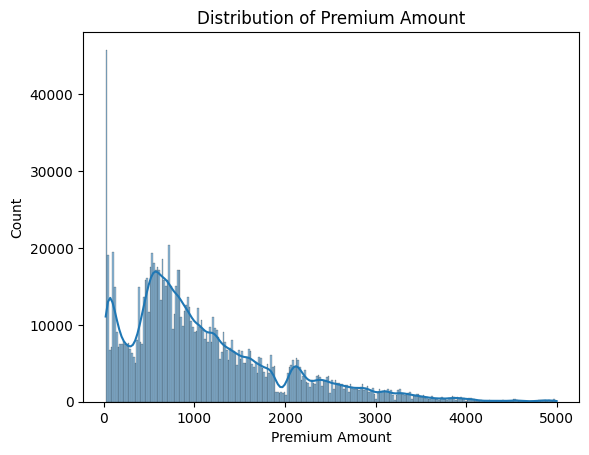

In [ ]:
sns.histplot(train[TARGET], kde=True)
plt.title("Distribution of Premium Amount")
plt.show()

In [ ]:
# Check missing values
missing_values = train.isnull().sum().sort_values(ascending=False)
print("Missing values in train:\n", missing_values)

Missing values in train:
 Previous Claims         364029
Occupation              358075
Credit Score            137882
Number of Dependents    109672
Customer Feedback        77824
Health Score             74076
Annual Income            44949
Age                      18705
Marital Status           18529
Vehicle Age                  6
Insurance Duration           1
Gender                       0
id                           0
Location                     0
Policy Type                  0
Education Level              0
Policy Start Date            0
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64


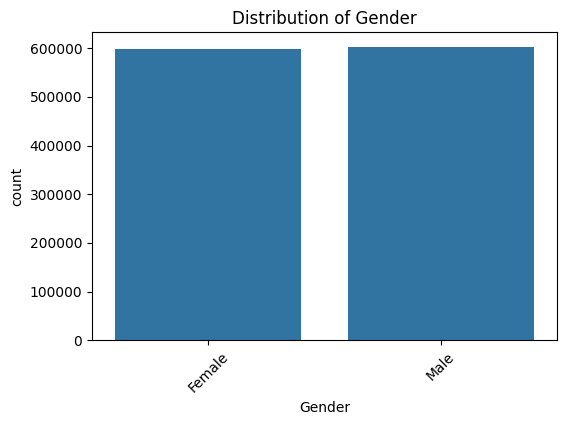

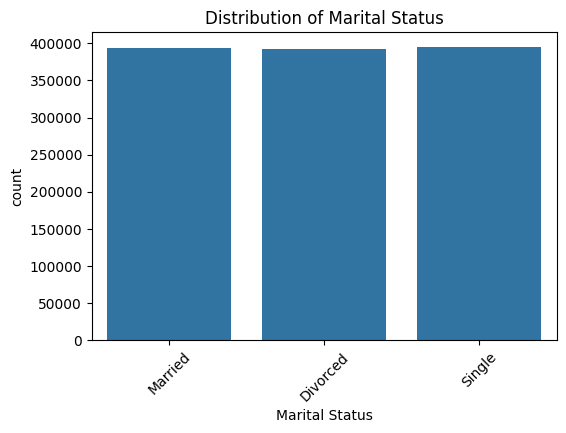

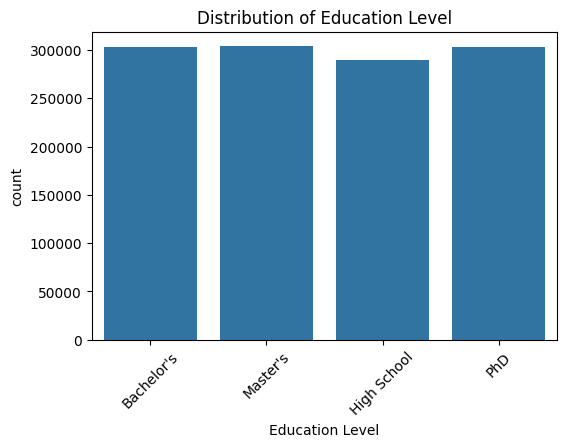

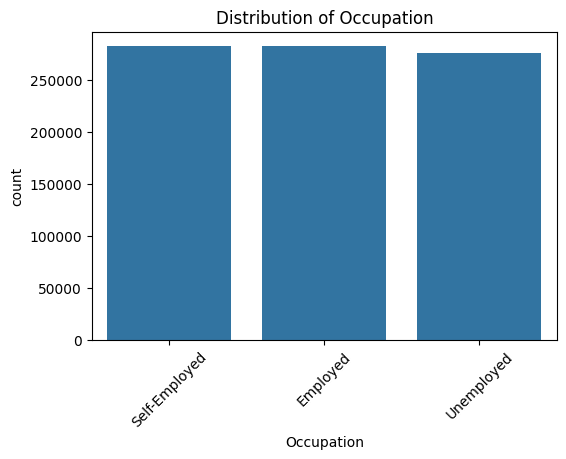

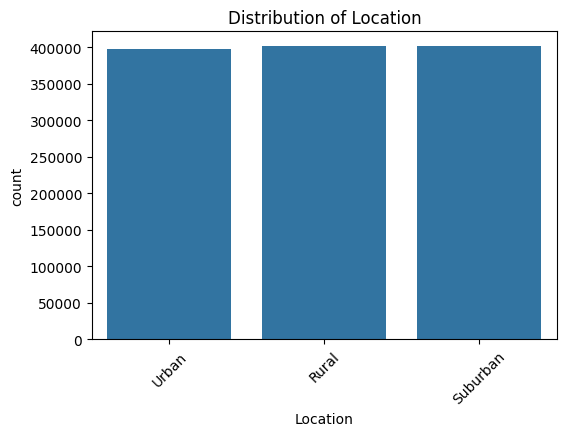

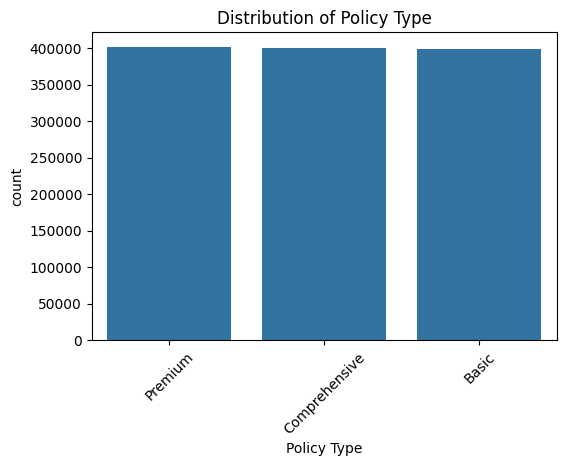

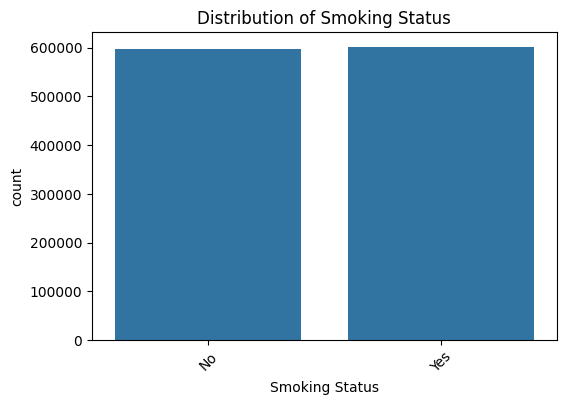

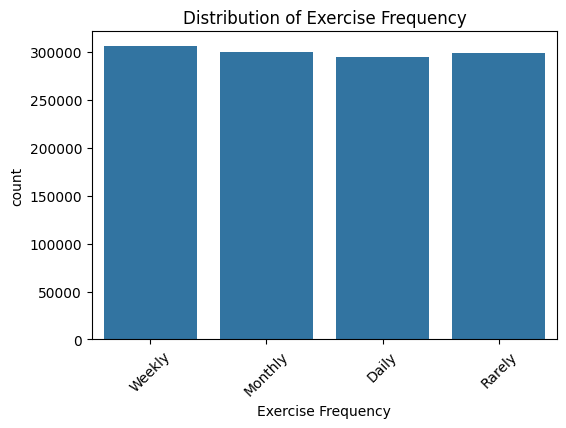

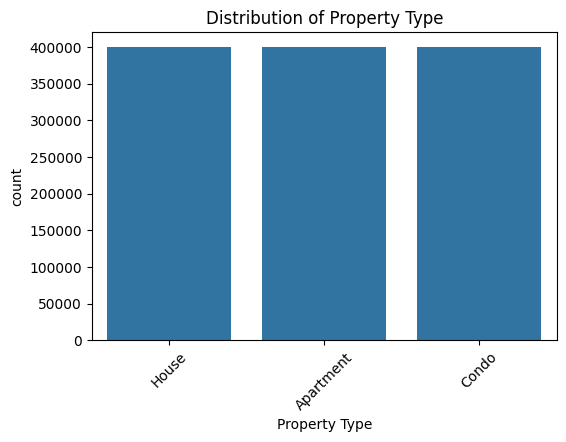

In [ ]:
# Categorical Features distribution
cat_features = ['Gender','Marital Status','Education Level','Occupation','Location','Policy Type','Smoking Status','Exercise Frequency','Property Type']

for c in cat_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=c, data=train)
    plt.title(f"Distribution of {c}")
    plt.xticks(rotation=45)
    plt.show()

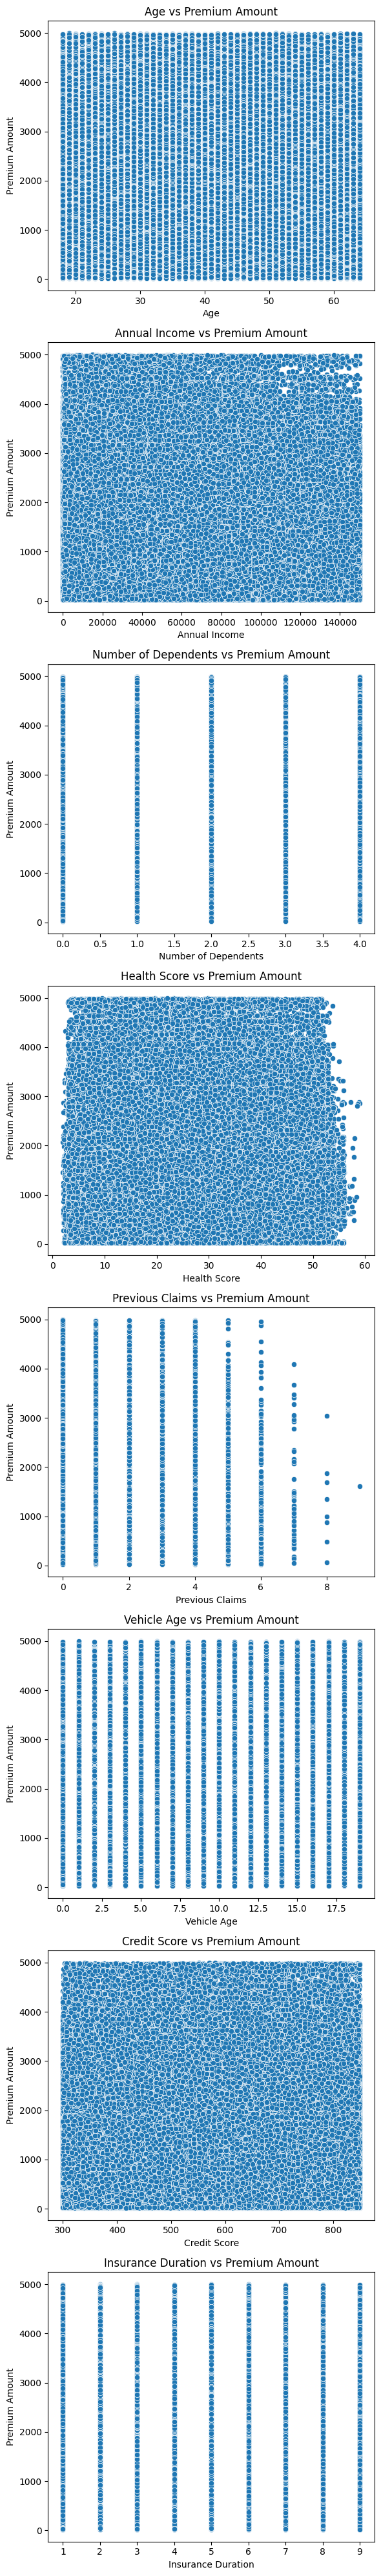

In [ ]:
# Relationship between numeric features and target
num_features = ['Age','Annual Income','Number of Dependents','Health Score',
                'Previous Claims','Vehicle Age','Credit Score','Insurance Duration']
fig, axes = plt.subplots(len(num_features), 1, figsize=(6, 40))

for i, col in enumerate(num_features):
    sns.scatterplot(x=train[col], y=train[TARGET], ax=axes[i])
    axes[i].set_title(f"{col} vs {TARGET}")
plt.tight_layout()
plt.show()

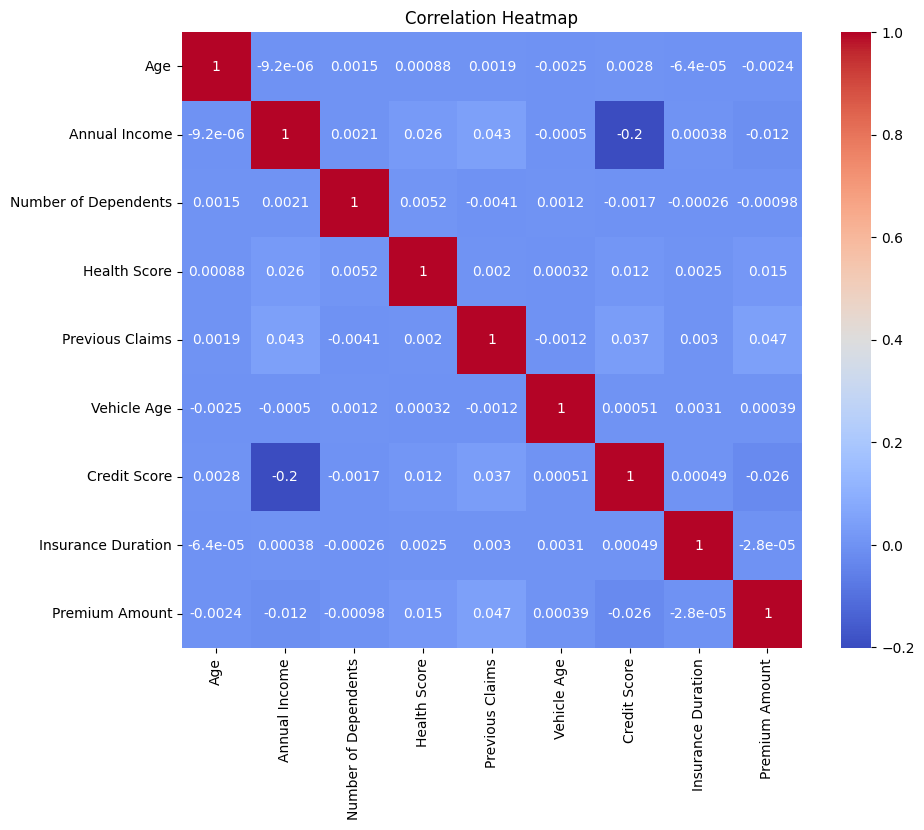

In [ ]:
# Check correlation among numerical features
corr = train[num_features+[TARGET]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# ========================================
# 4. Data Cleaning and Preprocessing
# ========================================

# Example of cleaning steps:
# - Fix incorrect data types
# Convert Policy Start Date to datetime if present and not in correct format
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'], errors='coerce')
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'], errors='coerce')
columns_with_missing = ['Previous Claims', 'Occupation', 'Credit Score',
                        'Number of Dependents', 'Customer Feedback',
                        'Health Score', 'Annual Income', 'Age',
                        'Marital Status', 'Vehicle Age', 'Insurance Duration'
                       ]

for col in columns_with_missing:
    # Create a new binary column indicating missingness
    train[col+'_missing'] = train[col].isnull().astype(int)
    test[col+'_missing'] = test[col].isnull().astype(int)
print(train.isnull().sum())

id                                   0
Age                              18705
Gender                               0
Annual Income                    44949
Marital Status                   18529
Number of Dependents            109672
Education Level                      0
Occupation                      358075
Health Score                     74076
Location                             0
Policy Type                          0
Previous Claims                 364029
Vehicle Age                          6
Credit Score                    137882
Insurance Duration                   1
Policy Start Date                    0
Customer Feedback                77824
Smoking Status                       0
Exercise Frequency                   0
Property Type                        0
Premium Amount                       0
Previous Claims_missing              0
Occupation_missing                   0
Credit Score_missing                 0
Number of Dependents_missing         0
Customer Feedback_missing

In [ ]:
# Address skewed features: 'Annual Income', 'Premium Amount', 'Health Score' may be skewed
# Apply log transform to reduce skewness if needed (only to non-negative features)
# We will be careful with transforming the target for RMSLE evaluation.

train['Annual Income'] = np.log1p(train['Annual Income'])
test['Annual Income'] = np.log1p(test['Annual Income'])

train['Health Score'] = np.log1p(train['Health Score'])
test['Health Score'] = np.log1p(test['Health Score'])
# Consider transforming the target:
# RMSLE is usually applied to positive targets. We can still predict on normal scale,
# but optimizing a model on a log-transformed target often helps.
train[TARGET] = np.log1p(train[TARGET])  # log-transform the target for modeling
# ========================================
# 5. Feature Engineering
# ========================================

# Example feature engineering:
# - Extract date features from 'Policy Start Date'
train['Policy_Year'] = train['Policy Start Date'].dt.year
train['Policy_Month'] = train['Policy Start Date'].dt.month
train['Policy_Day'] = train['Policy Start Date'].dt.day

test['Policy_Year'] = test['Policy Start Date'].dt.year
test['Policy_Month'] = test['Policy Start Date'].dt.month
test['Policy_Day'] = test['Policy Start Date'].dt.day
# Drop original date column if it's no longer needed
train.drop(['Policy Start Date'], axis=1, inplace=True)
test.drop(['Policy Start Date'], axis=1, inplace=True)

# Text feature: 'Customer Feedback'
# For example, we could do a length count or number of words as a simple feature
train['Feedback_Length'] = train['Customer Feedback'].astype(str).apply(lambda x: len(x))
test['Feedback_Length'] = test['Customer Feedback'].astype(str).apply(lambda x: len(x))

train['Feedback_WordCount'] = train['Customer Feedback'].astype(str).apply(lambda x: len(x.split()))
test['Feedback_WordCount'] = test['Customer Feedback'].astype(str).apply(lambda x: len(x.split()))
# Drop the raw text if we prefer not to use it directly
train.drop(['Customer Feedback'], axis=1, inplace=True)
test.drop(['Customer Feedback'], axis=1, inplace=True)

# For categorical variables, we will use one-hot or label encoding
# Let's use one-hot encoding for simplicity
all_data = pd.concat([train, test], sort=False)
all_data = pd.get_dummies(all_data, columns=cat_features, drop_first=True)

# Now split back into train and test
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]
train.shape

(1200000, 44)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 44 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   id                            1200000 non-null  int64  
 1   Age                           1181295 non-null  float64
 2   Annual Income                 1155051 non-null  float64
 3   Number of Dependents          1090328 non-null  float64
 4   Health Score                  1125924 non-null  float64
 5   Previous Claims               835971 non-null   float64
 6   Vehicle Age                   1199994 non-null  float64
 7   Credit Score                  1062118 non-null  float64
 8   Insurance Duration            1199999 non-null  float64
 9   Premium Amount                1200000 non-null  float64
 10  Previous Claims_missing       1200000 non-null  int64  
 11  Occupation_missing            1200000 non-null  int64  
 12  Credit Score_missing          120

In [ ]:
# Make sure target is still in train
# We moved our target earlier, so it's safe. Just reconfirm structure
y = train[TARGET]
X = train.drop([TARGET, ID_COL], axis=1)
X_test = test.drop([TARGET, ID_COL], axis=1, errors='ignore') # test doesn't have target

print("Final training shape:", X.shape)
print("Final test shape:", X_test.shape)

Final training shape: (1200000, 42)
Final test shape: (800000, 42)


In [ ]:
# ========================================
# 6. Train-Validation Split (Local)
# ========================================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# ========================================
# 7. Baseline Modeling with XGBoost
# ========================================

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Preliminary model
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

y_pred_val = xgb_reg.predict(X_val)
val_score = rmsle(np.expm1(y_val), np.expm1(y_pred_val))  # transform back the exponent
print("Baseline RMSLE on validation:", val_score)

Baseline RMSLE on validation: 1.0480830223536157


In [ ]:
!pip install xgboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
def objective(trial):
    # Hyperparameters
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'auto',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10)
    }
    # Use n_estimators as num_boost_round
    num_boost_round = trial.suggest_int('n_estimators', 100, 1000)

    # Using K-Fold for evaluation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmsle_scores = []
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]

        # Convert training and validation data to DMatrix
        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dvalid = xgb.DMatrix(X_vl, label=y_vl)

        evals = [(dvalid, 'eval')]
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=50,
            verbose_eval=False
        )

        # Use iteration_range to limit predictions to the best iteration found
        preds = model.predict(dvalid, iteration_range=(0, model.best_iteration))
        fold_score = rmsle(np.expm1(y_vl), np.expm1(preds))
        rmsle_scores.append(fold_score)

    return np.mean(rmsle_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Best RMSLE:", study.best_value)
print("Best parameters:", study.best_params)


[I 2025-03-30 10:00:34,934] A new study created in memory with name: no-name-7bde1c7e-5789-4325-beee-222e37ddccb8


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-03-30 10:02:12,492] Trial 0 finished with value: 1.048235334532411 and parameters: {'learning_rate': 0.23203082447710996, 'max_depth': 9, 'subsample': 0.6237072460344051, 'colsample_bytree': 0.5068556910345523, 'reg_alpha': 9.694805650195118, 'reg_lambda': 9.176105542581137, 'n_estimators': 849}. Best is trial 0 with value: 1.048235334532411.
[I 2025-03-30 10:12:40,315] Trial 1 finished with value: 1.0456073913314434 and parameters: {'learning_rate': 0.012024093904223494, 'max_depth': 7, 'subsample': 0.7838765874041749, 'colsample_bytree': 0.927482895613863, 'reg_alpha': 8.468488987720114, 'reg_lambda': 5.9574121167245595, 'n_estimators': 781}. Best is trial 1 with value: 1.0456073913314434.
[I 2025-03-30 10:18:06,733] Trial 2 finished with value: 1.048234865828527 and parameters: {'learning_rate': 0.023763144827529996, 'max_depth': 4, 'subsample': 0.7803521610097062, 'colsample_bytree': 0.942639837613334, 'reg_alpha': 9.453407232200286, 'reg_lambda': 2.535377425075684, 'n_esti

In [ ]:
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params, random_state=42)
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.927482895613863, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.012024093904223494, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=781, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# ========================================
# 9. Model Evaluation using RMSLE on Validation
# ========================================
# Already done cross-validation;
# If we have a separate test set (we do - but no target), we will just generate predictions:
# We'll trust cross-validation results. For final submission on Kaggle:
y_pred_test = final_model.predict(X_test)
# Remember to invert the log transform for predictions
y_pred_test = np.expm1(y_pred_test)

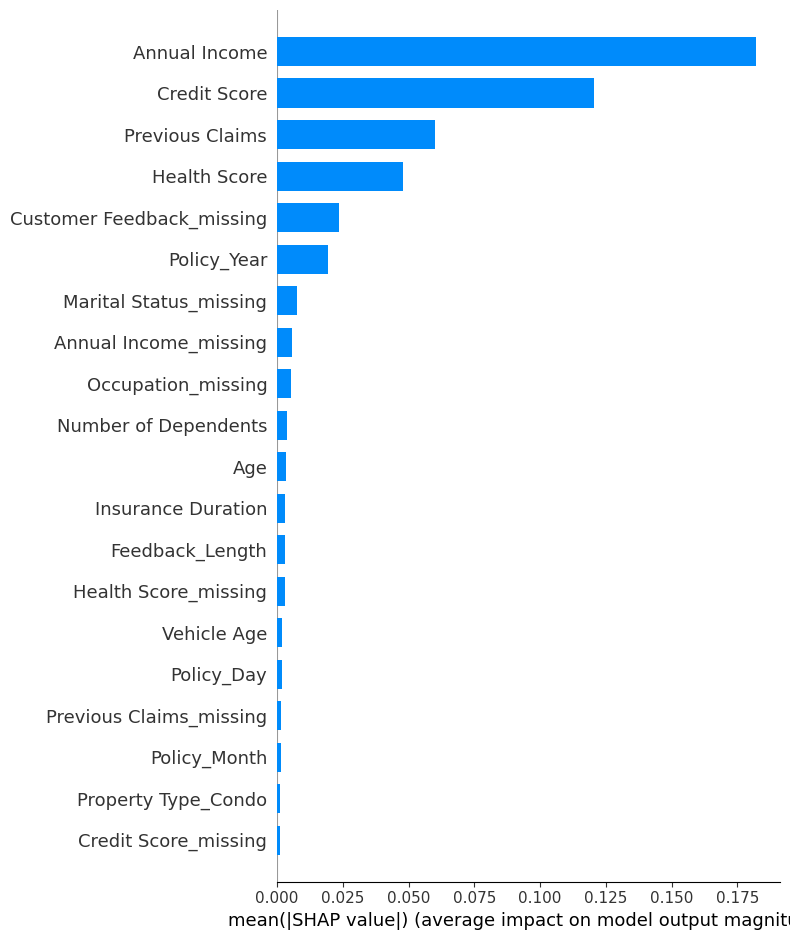

In [ ]:
# ========================================
# 10. Explainability with SHAP
# ========================================
# Use a subset of data to speed up SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X.sample(1000, random_state=42))
# Global Feature Importance
shap.summary_plot(shap_values, X.sample(1000, random_state=42), plot_type='bar')

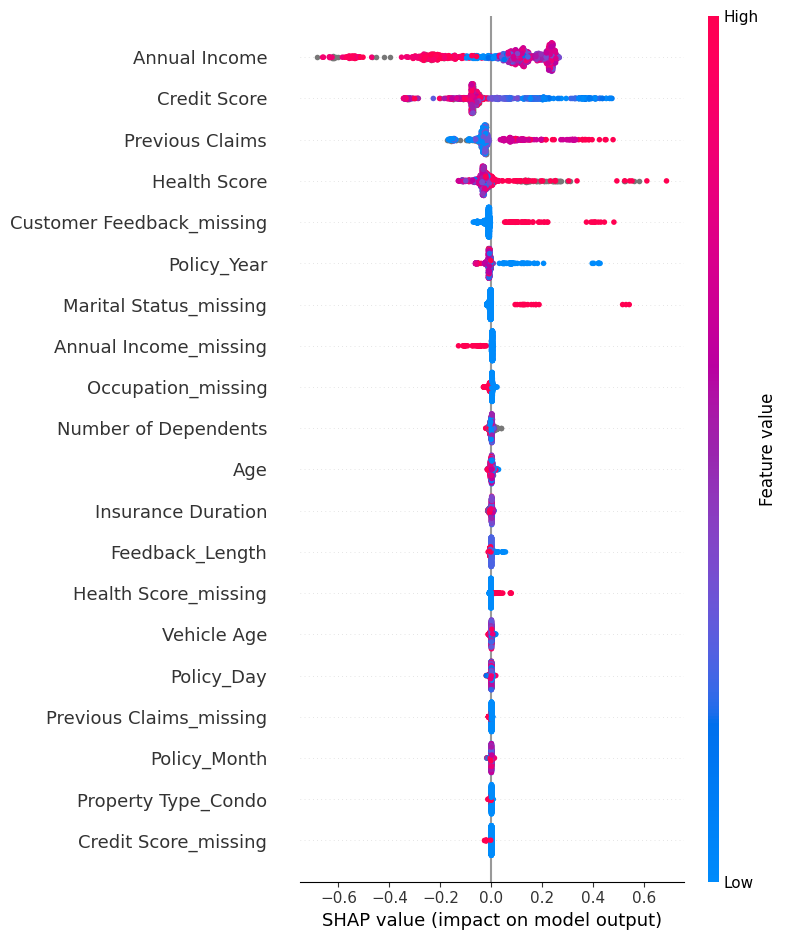

In [ ]:
shap.summary_plot(shap_values, X.sample(1000, random_state=42))


11. AdaBoost Implementation & Comparison

Training AdaBoost model and comparing with XGBoost...


[I 2025-04-16 03:10:29,102] A new study created in memory with name: no-name-0b221410-2a47-49f1-99e5-5c1e435651b8


AdaBoost baseline RMSLE on validation: 1.092536
XGBoost baseline RMSLE on validation: 1.048083

Optimizing AdaBoost hyperparameters 


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-04-16 03:11:05,463] Trial 0 finished with value: 1.1129885488150941 and parameters: {'n_estimators': 105, 'learning_rate': 0.4352011922206908, 'estimator__max_depth': 4}. Best is trial 0 with value: 1.1129885488150941.
[I 2025-04-16 03:12:01,720] Trial 1 finished with value: 1.079616673962123 and parameters: {'n_estimators': 32, 'learning_rate': 0.10492646437141104, 'estimator__max_depth': 4}. Best is trial 1 with value: 1.079616673962123.
[I 2025-04-16 03:13:28,645] Trial 2 finished with value: 1.1393686261904148 and parameters: {'n_estimators': 150, 'learning_rate': 0.2619674149369309, 'estimator__max_depth': 5}. Best is trial 1 with value: 1.079616673962123.
[I 2025-04-16 03:14:29,407] Trial 3 finished with value: 1.1045944779531127 and parameters: {'n_estimators': 75, 'learning_rate': 0.1662798768674103, 'estimator__max_depth': 3}. Best is trial 1 with value: 1.079616673962123.
[I 2025-04-16 03:15:05,383] Trial 4 finished with value: 1.103891533422532 and parameters: {'n_es

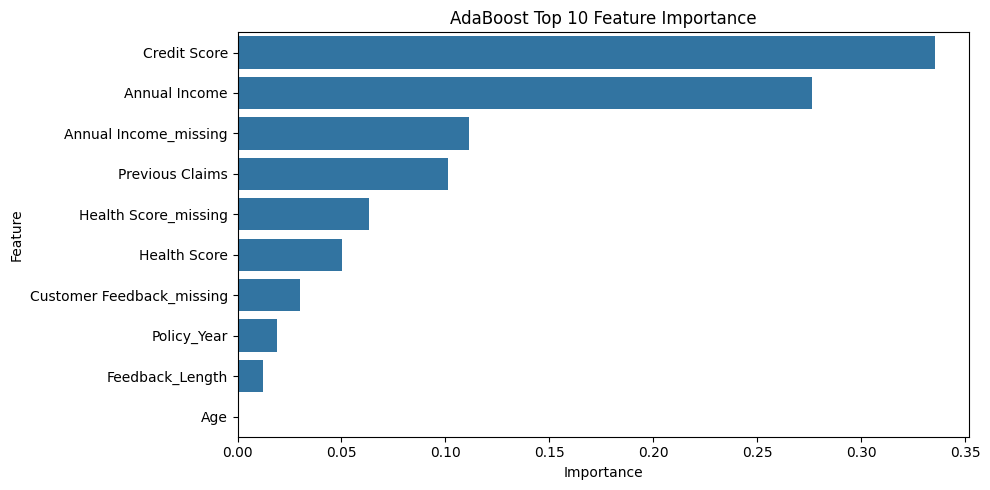


==== Model Comparison ====
XGBoost baseline RMSLE: 1.048083
AdaBoost best RMSLE: 1.079617
Performance difference: 0.031534
Better model: XGBoost
AdaBoost predictions saved to 'adaboost_submission.csv'


In [ ]:
# ========================================
# 11. AdaBoost Implementation & Comparison (Optimized)
# ========================================

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer

print("\n========================================")
print("11. AdaBoost Implementation & Comparison")
print("========================================\n")

print("Training AdaBoost model and comparing with XGBoost...")

sample_size = int(X.shape[0] * 0.2)
X_sample = X.sample(sample_size, random_state=42)
y_sample = y.loc[X_sample.index]

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

base_estimator = DecisionTreeRegressor(max_depth=3)
adaboost_model = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)

adaboost_model.fit(X_train_imputed, y_train)

y_pred_ada = adaboost_model.predict(X_val_imputed)

ada_rmsle = rmsle(np.expm1(y_val), np.expm1(y_pred_ada))
print(f"AdaBoost baseline RMSLE on validation: {ada_rmsle:.6f}")
print(f"XGBoost baseline RMSLE on validation: {val_score:.6f}")

def adaboost_objective(trial):
    # Much smaller parameter ranges
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 150),  # Reduced range
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.5),  # Narrower range
        'estimator__max_depth': trial.suggest_int('estimator__max_depth', 2, 5),  # Smaller range
    }

    base_est = DecisionTreeRegressor(max_depth=params['estimator__max_depth'], random_state=42)

    # Use simpler cross-validation (2-fold instead of 3-fold)
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    rmsle_scores = []

    # Use the sampled subset of data for faster tuning
    X_sample_imputed = imputer.fit_transform(X_sample)

    for train_idx, val_idx in kf.split(X_sample_imputed):
        X_tr, X_vl = X_sample_imputed[train_idx], X_sample_imputed[val_idx]
        y_tr, y_vl = y_sample.iloc[train_idx], y_sample.iloc[val_idx]

        model = AdaBoostRegressor(
            estimator=base_est,
            n_estimators=params['n_estimators'],
            learning_rate=params['learning_rate'],
            random_state=42
        )

        model.fit(X_tr, y_tr)
        preds = model.predict(X_vl)
        fold_score = rmsle(np.expm1(y_vl), np.expm1(preds))
        rmsle_scores.append(fold_score)

    return np.mean(rmsle_scores)

# Fewer trials for optimization
print("\nOptimizing AdaBoost hyperparameters ")
ada_study = optuna.create_study(direction='minimize')
ada_study.optimize(adaboost_objective, n_trials=8, show_progress_bar=True)  # Reduced trials

print("Best AdaBoost RMSLE:", ada_study.best_value)
print("Best AdaBoost parameters:", ada_study.best_params)

# Train final AdaBoost model with best parameters
best_base_est = DecisionTreeRegressor(
    max_depth=ada_study.best_params['estimator__max_depth'],
    random_state=42
)
best_adaboost = AdaBoostRegressor(
    estimator=best_base_est,
    n_estimators=ada_study.best_params['n_estimators'],
    learning_rate=ada_study.best_params['learning_rate'],
    random_state=42
)

# Prepare full imputed dataset for final training
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# Train on full dataset with best parameters
best_adaboost.fit(X_imputed, y)

# Make test predictions
y_pred_test_ada = best_adaboost.predict(X_test_imputed)
y_pred_test_ada = np.expm1(y_pred_test_ada)

# Feature importance (top 10 only for faster visualization)
feature_importances = best_adaboost.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('AdaBoost Top 10 Feature Importance')
plt.tight_layout()
plt.show()

# Compare results - WITH FIX FOR STUDY VARIABLE
print("\n==== Model Comparison ====")

# Check if XGBoost study exists, otherwise use val_score
try:
    xgb_best_score = study.best_value
    print(f"XGBoost best RMSLE: {xgb_best_score:.6f}")
except NameError:
    xgb_best_score = val_score  # Use baseline score if study not available
    print(f"XGBoost baseline RMSLE: {xgb_best_score:.6f}")

print(f"AdaBoost best RMSLE: {ada_study.best_value:.6f}")
print(f"Performance difference: {abs(xgb_best_score - ada_study.best_value):.6f}")
better_model = "XGBoost" if xgb_best_score < ada_study.best_value else "AdaBoost"
print(f"Better model: {better_model}")